TODO:

- Tidy
- Fix p-values
- Improve non-paralog control 
- Change code to add in additional 1-isoform genes


Thoughts:

- How comparable is AA identity between isoforms and between paralogs, since paralogs have evolutionary drift and isoforms don't
- Maybe paralogs can function as redundant backups in a way that isoforms can't
- Maybe paralogs can also totally functionally diverge in a way that isoforms can't

In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from data_loading import (load_paralogs_vs_isoforms_comparison_table,
                          load_annotated_TFiso1_collection,
                          load_tf_families,
)

from plotting import violinplot_reflected

In [2]:
df = load_paralogs_vs_isoforms_comparison_table()
df.loc[~((df['n_positive_PPI_a'] >= 1) & (df['n_positive_PPI_b'] >= 1)),
       'PPI_jaccard'] = np.nan
df['PPI_Jaccard_d'] = 1 - df['PPI_jaccard']
df['PDI_Jaccard_d'] = 1 - df['PDI_jaccard']

In [ ]:
# TMP TEST
df.loc[(df['activation_a'].abs() < 1) &
       (df['activation_b'].abs() < 1), 
       'activation_abs_fold_change_log2'] = np.nan

<function _ViolinPlotter.fit_kde at 0x12d0158b0>
<function _ViolinPlotter.fit_kde at 0x12d0158b0>


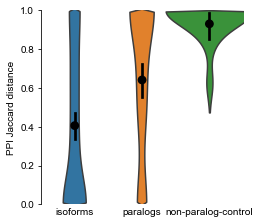

In [8]:
# TODO: add p-values
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=3.5, h=3)
violinplot_reflected(data=df,
            x='category',
            y='PPI_Jaccard_d',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            inner=None,
            width=1.3,
            clip_on=False,
            ax=ax,
            )
sns.pointplot(data=df,
            x='category',
            y='PPI_Jaccard_d',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            linestyles='',
            ax=ax,
            clip_on=False,
            )
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylim(0, 1)
ax.set_xlabel('')
ax.xaxis.set_tick_params(length=0)
ax.set_ylabel('PPI Jaccard distance')
fig.savefig('../figures/isoforms_vs_paralogs_PPI_jaccard_violin.pdf',
            bbox_inches='tight')

<function _ViolinPlotter.fit_kde at 0x12d0158b0>
<function _ViolinPlotter.fit_kde at 0x12d0158b0>


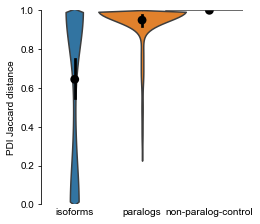

In [20]:
# TODO: change bandwidth of violin plot????
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=3.5, h=3)
violinplot_reflected(data=df,
            x='category',
            y='PDI_Jaccard_d',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            inner=None,
            width=1.3,
            clip_on=False,
            ax=ax,
            )
sns.pointplot(data=df,
            x='category',
            y='PDI_Jaccard_d',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            linestyles='',
            ax=ax,
            clip_on=False,
            )
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylim(0, 1)
ax.set_xlabel('')
ax.xaxis.set_tick_params(length=0)
ax.set_ylabel('PDI Jaccard distance')
fig.savefig('../figures/isoforms_vs_paralogs_PDI_jaccard_violin.pdf',
            bbox_inches='tight')

<function _ViolinPlotter.fit_kde at 0x12d0158b0>
<function _ViolinPlotter.fit_kde at 0x12d0158b0>


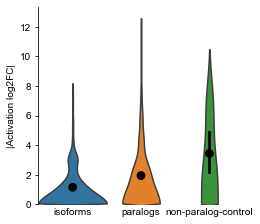

In [24]:
# HACK should just be using violoin plot but it's broken by the reflection
# HACK so just putting very high upper bound
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=3.5, h=3)
violinplot_reflected(data=df,
            x='category',
            y='activation_abs_fold_change_log2',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            inner=None,
            width=1.,
            ub=9999999,
            clip_on=False,
            ax=ax,
            )
sns.pointplot(data=df,
            x='category',
            y='activation_abs_fold_change_log2',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            linestyles='',
            ax=ax,
            clip_on=False,
            )
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylim(0, None)
ax.set_xlabel('')
ax.xaxis.set_tick_params(length=0)
ax.set_ylabel('|Activation log2FC|')
fig.savefig('../figures/isoforms_vs_paralogs_activation_violin.pdf',
            bbox_inches='tight')

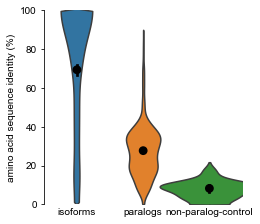

In [3]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=3.5, h=3)
violinplot_reflected(data=df,
            x='category',
            y='aa_seq_pct_identity',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            inner=None,
            width=1.5,
            ub=100,
            clip_on=False,
            ax=ax,
            )
sns.pointplot(data=df,
            x='category',
            y='aa_seq_pct_identity',
            order=['isoforms', 'paralogs', 'non-paralog-control'],
            color='black',
            linestyles='',
            ax=ax,
            clip_on=False,
            )
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylim(0, 100)
ax.set_xlabel('')
ax.xaxis.set_tick_params(length=0)
ax.set_ylabel('amino acid sequence identity (%)')
fig.savefig('../figures/isoforms_vs_paralogs_seq_id_violin.pdf',
            bbox_inches='tight')

In [34]:
def assay_vs_seq_similarity_plot(
    var, 
    window_size,
    n_min,
    y_label,
    color,
    y_max=None,
    y_ticks=None,
    y_ticks_minor=None,
    y_pos_p_value=1,
    alpha_points=0.15,
    ):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(3, 3)
    fig_path = f'../figures/isoforms_vs_paralogs_aa_id_vs_{var}_fixed_window.pdf'

    # calculate bootstrap uncertainty by number of data points
    err = {}
    def get_bootstrap_error_for_n_data_points(n):
        if n in err:
            return err[n]
        all_vals = df[var].dropna().values
        rnd_means = []
        for _i in range(1000):
            rnd_means.append(
                np.mean(np.random.choice(all_vals, size=n, replace=True))
                )
        mean = np.mean(rnd_means)
        err_up = np.quantile(rnd_means, q=0.84) - mean
        err_dn = mean - np.quantile(rnd_means, q=0.16)
        err[n] = max([err_up, err_dn])  # taking a conservative approach
        return err[n]
                

    # p-value using permutation test within a window
    # use window where they overlap the most, as quantified by
    # the max across all windows of the min of the two #pairs 
    # (# paralog pairs and # isoform pairs) in each window
    max_min_n = 0
    for i in range(-window_size, 100):
        binned_rows = (df[var].notnull() 
                    & (df['aa_seq_pct_identity'] >= i)
                    & (df['aa_seq_pct_identity'] < i + window_size))
        min_n = min([
            (binned_rows & (df['category'] == 'isoforms')).sum(),
            (binned_rows & (df['category'] == 'paralogs')).sum()
        ])
        if min_n > max_min_n:
            bin_low = i
            bin_high = i + window_size
            max_min_n = min_n
    overlap = df.loc[df['category'].isin(['isoforms', 'paralogs'])
                    & df[var].notnull()
                    & (df['aa_seq_pct_identity'] >= bin_low)
                    & (df['aa_seq_pct_identity'] < bin_high),
                    ['category', var]]
    val_a = overlap.loc[overlap['category'] == 'isoforms', var].mean()
    val_b = overlap.loc[overlap['category'] == 'paralogs', var].mean()
    obs_val = val_a - val_b
    all_vals = overlap[var].values
    rnd_vals = []
    n_a = (overlap['category'] == 'isoforms').sum()
    np.random.seed(84349723)
    for _i in range(20000):
        shuffled = np.random.choice(all_vals, size=len(all_vals), replace=False)
        rnd_vals.append(shuffled[:n_a].mean() - shuffled[n_a:].mean())
    rnd_vals = np.array(rnd_vals)
    p_val = ((rnd_vals >= obs_val).sum() / len(rnd_vals)) * 2
    print(len(all_vals), n_a)
    print(val_a, val_b)
    print(bin_low, bin_high)
    print(obs_val)
    print('p=', p_val)


    for cat in ['isoforms', 'paralogs']:
        xy = df.loc[(df['category'] == cat) &
            (df[var].notnull()),
                ['aa_seq_pct_identity', var]].values
        ax.scatter(xy[:, 0], 
                xy[:, 1],
                clip_on=False, 
                alpha=alpha_points,
                label=cat,
                lw=0,
                )
        x, avrg, ci_dn, ci_up = [], [], [], []
        for i in range(-window_size, 100):
            subset = df.loc[(df['category'] == cat) 
                            & (df[var].notnull())
                            & (df['aa_seq_pct_identity'] >= i)
                            & (df['aa_seq_pct_identity'] < i + window_size),
                            ['aa_seq_pct_identity', var]]
            n = subset.shape[0]
            if n < n_min:
                continue
            x.append(subset['aa_seq_pct_identity'].mean())
            avrg.append(subset[var].mean())
            ci_dn.append(max(avrg[-1] - get_bootstrap_error_for_n_data_points(n), 0))
            ci_up.append(min(avrg[-1] + get_bootstrap_error_for_n_data_points(n), y_max))

        ax.plot(x, avrg)
        ax.fill_between(x=x, 
                        y1=ci_dn, 
                        y2=ci_up,
                        alpha=0.5,
                        color=color[cat],
                        lw=0,
                        )
    ax.text(s=f'P = {p_val:.3f}',
            x=bin_low + window_size / 2,
            y=y_pos_p_value,
            ha='center',
            va='top',
            )

    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
    ax.set_xlabel('% AA sequence ID')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, y_max)
    ax.set_xticks(range(0, 101, 20))
    ax.set_xticks(range(0, 101, 10), minor=True)
    if y_ticks is not None:
        ax.set_yticks(y_ticks)
    if y_ticks_minor is not None:
        ax.set_yticks(y_ticks_minor, minor=True)
    ax.set_ylabel(y_label)
    #ax.set_title('Sliding window mean, window size 20%, minimum points 10')
    #fig.legend(loc='center left', bbox_to_anchor=[0.95, 0.5])
    fig.savefig(fig_path, bbox_inches='tight')

47 20
0.9614468864468864 0.8680702014035347
29 69
0.09337668504335161
p= 0.0428


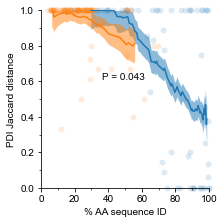

In [35]:
assay_vs_seq_similarity_plot(var='PDI_Jaccard_d',
                             window_size=40,
                             n_min=10,
                             y_label='PDI Jaccard distance',
                             color={'isoforms': 'C0', 'paralogs': 'C1', 'non-paralog-control': 'C2'},
                             y_max=1,
                             y_ticks=np.linspace(0, 1, 6),
                             y_ticks_minor=np.linspace(0, 1, 11),
                             y_pos_p_value=0.65,
                             )

45 23
0.6606398489520082 0.5508320052962911
33 73
0.10980784365571716
p= 0.1672


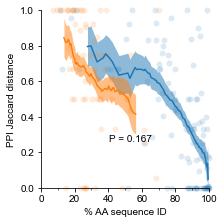

In [32]:
# TODO: y pos to put p-value
assay_vs_seq_similarity_plot(var='PPI_Jaccard_d',
                             window_size=40,
                             n_min=10,
                             y_label='PPI Jaccard distance',
                             color={'isoforms': 'C0', 'paralogs': 'C1', 'non-paralog-control': 'C2'},
                             y_max=1,
                             y_pos_p_value=0.3,
                             )

178 90
1.4648255435989885 1.1861360242021168
37 77
0.2786895193968717
p= 0.1222


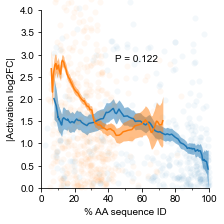

In [33]:
assay_vs_seq_similarity_plot(var='activation_abs_fold_change_log2',
                             window_size=40,
                             n_min=10,
                             y_label='|Activation log2FC|',
                             color={'isoforms': 'C0', 'paralogs': 'C1', 'non-paralog-control': 'C2'},
                             y_max=4,  
                             alpha_points=0.05,
                             y_pos_p_value=3,                       
                             )